In [2]:
import os
import sys
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

sys.path.insert(0, os.path.abspath('../../fully-observed-policy-learning/'))
from synthetic import data_generation, indirect_learning, direct_learning

from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style('white')
sns.set_palette('deep')

plt.rcParams.update({'font.size': 20})

### Run experiment

In [ ]:
# Random seed
SEED = 49

# Number of trials to run
num_trials = 25

#### Data Generation ####

# Generate ground truth coefficients
coeffs = data_generation.generate_model_coeffs()

# Generate held out test data + filter to specimens with non-uniform outcomes
X_test_raw, X_test, y_test = data_generation.generate_data(1000000, coeffs, seed=SEED)
max_treatable = y_test.max(axis=1).mean()

# Filter evaluation set to cases where outcomes are not uniform across all treatments (i.e., not all 0's or all 1's)
y_test_sums = y_test.sum(axis=1)
X_test_raw_filtered = X_test_raw[(y_test_sums > 0) & (y_test_sums < 3)]
y_test_filtered = y_test[(y_test_sums > 0) & (y_test_sums < 3)]


#### Compute Bayes optimal treatment effectiveness ####
optimal = data_generation.get_bayes_outcome(X_test_raw_filtered, y_test_filtered)
print(f'Bayes optimal treatment rate in (filtered) test set is: {optimal}')


#### Run indirect and policy learning for selected training set sizes ####
n_samples_list = [250, 500, 1000, 2000, 5000, 10000]

mean_outcomes_indirect_final, mean_outcomes_direct_final = [], []
stdev_outcomes_indirect_final, stdev_outcomes_direct_final = [], []

for n_samples in n_samples_list:

    print(f'Processing results for {n_samples} training samples')

    indirect_outcomes_for_trial, direct_outcomes_for_trial = [], []

    for i in tqdm(range(num_trials)):
        X_train_raw, X_train, y_train = data_generation.generate_data(n_samples, coeffs,
                                                                      seed=SEED+i)

        # Indirect learning
        mean_outcome_indirect = indirect_learning.run_indirect_policy_learning(
                                                X_train_raw, X_test_raw_filtered,                                                    
                                                y_train, y_test_filtered)
        indirect_outcomes_for_trial.append(mean_outcome_indirect)

        # Direct learning 
        mean_outcome_direct = direct_learning.run_direct_policy_learning(
                                                 X_train_raw, X_test_raw_filtered,
                                                 y_train, y_test_filtered, 
                                                 lr=0.1, num_epochs=50,
                                                 lambda_reg=0.001, split_val=False)

        direct_outcomes_for_trial.append(mean_outcome_direct)


    mean_outcomes_indirect_final.append(np.mean(indirect_outcomes_for_trial))
    mean_outcomes_direct_final.append(np.mean(direct_outcomes_for_trial))

    stdev_outcomes_indirect_final.append(np.std(indirect_outcomes_for_trial))
    stdev_outcomes_direct_final.append(np.std(direct_outcomes_for_trial))


Bayes optimal treatment rate in (filtered) test set is: 0.7049969281179602
Processing results for 250 training samples



Processing results for 500 training samples



Processing results for 1000 training samples



Processing results for 2000 training samples



Processing results for 5000 training samples



Processing results for 10000 training samples


In [ ]:
mean_outcomes_indirect_final, mean_outcomes_direct_final

### Plot results

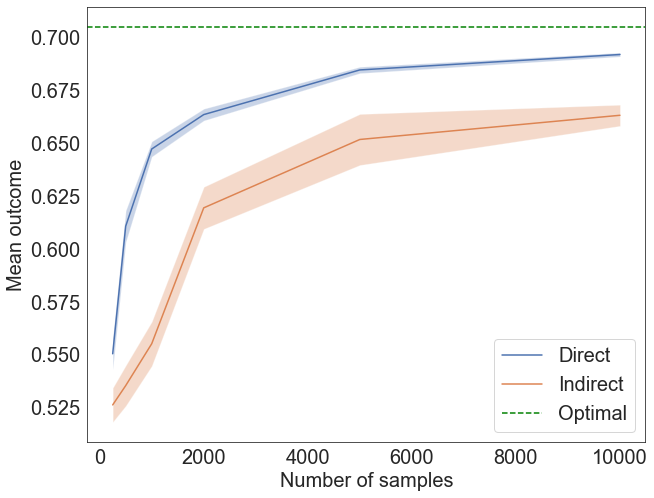

In [5]:
plt.figure(figsize=(10,8))

lower_bound_direct = [
    (mean - stdev/np.sqrt(num_trials))
    for (mean, stdev) in zip(mean_outcomes_direct_final, stdev_outcomes_direct_final)
]

upper_bound_direct = [
    (mean + stdev/np.sqrt(num_trials))
    for (mean, stdev) in zip(mean_outcomes_direct_final, stdev_outcomes_direct_final)
]

lower_bound_indirect = [
    (mean - stdev/np.sqrt(num_trials))
    for (mean, stdev) in zip(mean_outcomes_indirect_final, stdev_outcomes_indirect_final)
]

upper_bound_indirect = [
    (mean + stdev/np.sqrt(num_trials))
    for (mean, stdev) in zip(mean_outcomes_indirect_final, stdev_outcomes_indirect_final)
]

plt.plot(n_samples_list,
         (np.array(mean_outcomes_direct_final)),
         label='Direct')
plt.fill_between(n_samples_list, 
                 lower_bound_direct, upper_bound_direct, 
                 alpha=.3)

plt.plot(n_samples_list,
        (np.array(mean_outcomes_indirect_final)),
        label='Indirect')
plt.fill_between(n_samples_list, 
                 lower_bound_indirect, upper_bound_indirect, 
                 alpha=.3)

plt.axhline(y=optimal, linestyle='--',
            label='Optimal',  color='g')

plt.xlabel("Number of samples")
plt.ylabel("Mean outcome")
plt.legend();